In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import  date

In [2]:
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [3]:
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')
df=pd.read_csv('US_accidents_for_5_states.csv')

In [4]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

dd=df.copy()

dd=dd[dd['State']=='CA']
print(len(dd))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993530 entries, 0 to 993529
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             993530 non-null  int64         
 1   ID                     993530 non-null  object        
 2   Source                 993530 non-null  object        
 3   TMC                    623281 non-null  float64       
 4   Severity               993530 non-null  int64         
 5   Start_Time             993530 non-null  datetime64[ns]
 6   End_Time               993530 non-null  datetime64[ns]
 7   Start_Lat              993530 non-null  float64       
 8   Start_Lng              993530 non-null  float64       
 9   End_Lat                370249 non-null  float64       
 10  End_Lng                370249 non-null  float64       
 11  Distance(mi)           993530 non-null  float64       
 12  Description            993530 non-null  obje

In [5]:
print(len(dd.columns))
cols = dd.columns[dd.isnull().mean()>0.5]
dd.drop(cols, axis=1,inplace=True)

print(dd.shape)

print(dd.info())

print(dd.Sunrise_Sunset.unique())

unwanted_cols=['Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Weather_Timestamp','TMC']
dd.drop(unwanted_cols, axis=1,inplace=True)

print(dd.shape)

print(dd.isnull().sum())

print(len(dd))

56
(816825, 51)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 816825 entries, 0 to 993529
Data columns (total 51 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0             816825 non-null  int64         
 1   ID                     816825 non-null  object        
 2   Source                 816825 non-null  object        
 3   TMC                    485943 non-null  float64       
 4   Severity               816825 non-null  int64         
 5   Start_Time             816825 non-null  datetime64[ns]
 6   End_Time               816825 non-null  datetime64[ns]
 7   Start_Lat              816825 non-null  float64       
 8   Start_Lng              816825 non-null  float64       
 9   Distance(mi)           816825 non-null  float64       
 10  Description            816825 non-null  object        
 11  Street                 816825 non-null  object        
 12  Side                   81682

56.0
73.0
17.0
1705 6127


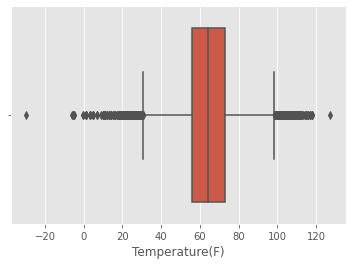

In [6]:
#plotting the box plots and finding the outliers
sns.boxplot(data=dd,x=dd['Temperature(F)'])
Q1=dd['Temperature(F)'].quantile(0.25)
Q3=dd['Temperature(F)'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
iqr_range=1.5*IQR
Lower_bound=Q1-iqr_range
Upper_bound=Q3+iqr_range
lower_outliers=dd[dd['Temperature(F)']<Lower_bound]
upper_outliers=dd[dd['Temperature(F)']>Upper_bound]
print(len(lower_outliers),len(upper_outliers))

19634
64.97231290870067 64.0
64.0
0


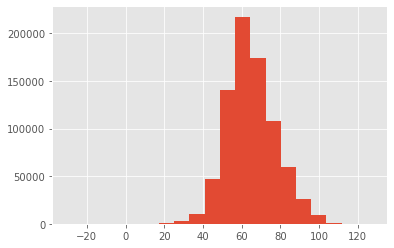

In [7]:
#Filling the temperature column missing values with its mean
dd_temperature=dd["Temperature(F)"]
#plotting the temperature histogram
dd_temperature.hist(bins=20)
#approximately follows normal distribution
print(dd["Temperature(F)"].isnull().sum())
#filling the missing values with the median
median_temperature=dd_temperature.median()
mean_temperature=dd_temperature.mean()
print(mean_temperature,median_temperature)
#calculating the median and mean temperature and since both are very close it is normal ditribution
print(median_temperature)
#filling the median temperature into the missing values since we are keeping the outliers
dd["Temperature(F)"].fillna(median_temperature, inplace=True)
#ensuring that there are no more null values in temperature
print(dd['Temperature(F)'].isnull().sum())

42.0
78.0
36.0
0 0


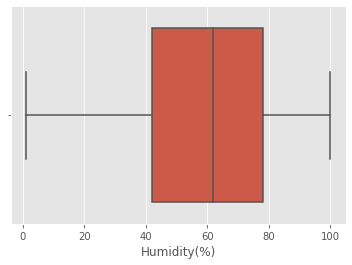

In [8]:
#plotting the box plots and finding the outliers
sns.boxplot(data=dd,x=dd['Humidity(%)'])
Q1=dd['Humidity(%)'].quantile(0.25)
Q3=dd['Humidity(%)'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
iqr_range=1.5*IQR
Lower_bound=Q1-iqr_range
Upper_bound=Q3+iqr_range
lower_outliers=dd[dd['Humidity(%)']<Lower_bound]
upper_outliers=dd[dd['Humidity(%)']>Upper_bound]
print(len(lower_outliers),len(upper_outliers))

21010
59.56618058217048 62.0
59.56618058217048
0


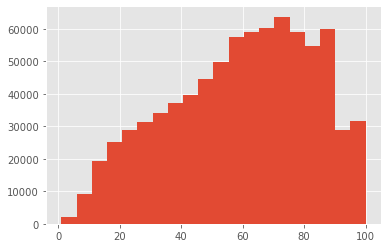

In [9]:
#Filling the humidity column missing values with its mean
dd_humidity=dd["Humidity(%)"]
#plotting the humidity histogram
dd_humidity.hist(bins=20)
#approximately follows normal distribution
print(dd["Humidity(%)"].isnull().sum())
#filling the missing values with the mean
median_humidity=dd_humidity.median()
mean_humidity=dd_humidity.mean()
print(mean_humidity,median_humidity)
#calculating the median and mean humidity and it is left-skewed ditribution
print(mean_humidity)
#filling the median temperature into the missing values since we are keeping the outliers
dd["Humidity(%)"].fillna(mean_humidity, inplace=True)
#ensuring that there are no more null values in temperature
print(dd['Humidity(%)'].isnull().sum())


29.8
30.03
0.23000000000000043
93557 2662


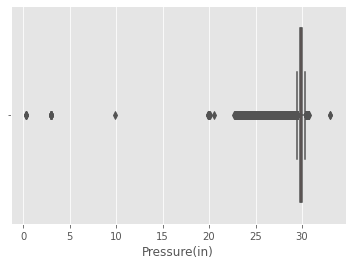

In [10]:
#plotting the box plots and finding the outliers
sns.boxplot(data=dd,x=dd['Pressure(in)'])
Q1=dd['Pressure(in)'].quantile(0.25)
Q3=dd['Pressure(in)'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
iqr_range=1.5*IQR
Lower_bound=Q1-iqr_range
Upper_bound=Q3+iqr_range
lower_outliers=dd[dd['Pressure(in)']<Lower_bound]
upper_outliers=dd[dd['Pressure(in)']>Upper_bound]
print(len(lower_outliers),len(upper_outliers))

In [11]:
#using the concept of flooring and capping
print(dd['Pressure(in)'].quantile(0.10)) #29.28
print(dd['Pressure(in)'].quantile(0.90)) #30.12
print(dd['Pressure(in)'].skew())  #-7.44688



29.28
30.120000000000005
-7.446881362975124


14783
29.793914445876887 29.92
-1.3228426110129212
29.860323262372795 29.92
0


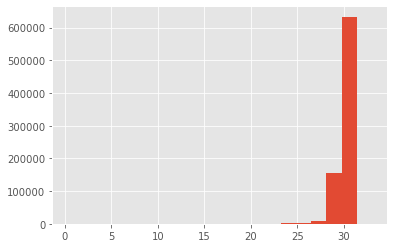

In [12]:
#Filling the Pressure column missing values with its mean
dd_Pressure=dd["Pressure(in)"]
#plotting the Pressure histogram
dd_Pressure.hist(bins=20)
#approximately follows normal distribution
print(dd["Pressure(in)"].isnull().sum())
#filling the missing values with the concept of flooring and capping
median_Pressure=dd_Pressure.median()
mean_Pressure=dd_Pressure.mean()
print(mean_Pressure,median_Pressure)
#calculating the median and mean pressure and it is left-skewed ditribution
dd["Pressure(in)"] = np.where(dd["Pressure(in)"] <29.28, 29.28,dd['Pressure(in)'])
dd["Pressure(in)"] = np.where(dd["Pressure(in)"] >30.12, 30.12,dd['Pressure(in)'])
print(dd['Pressure(in)'].skew())
#improved skew value from -7.44 to -1.322
#new mean and median
new_median_Pressure=dd_Pressure.median()
new_mean_Pressure=dd_Pressure.mean()
print(new_mean_Pressure,new_median_Pressure)
dd["Pressure(in)"].fillna(new_median_Pressure, inplace=True)
#ensuring that there are no more null values in temperature
print(dd['Pressure(in)'].isnull().sum())

10.0
10.0
0.0
168095 708


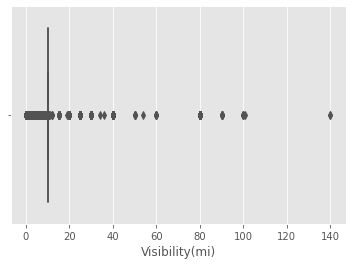

In [13]:
#visibility

#plotting the box plots and finding the outliers
sns.boxplot(data=dd,x=dd['Visibility(mi)'])
Q1=dd['Visibility(mi)'].quantile(0.25)
Q3=dd['Visibility(mi)'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
iqr_range=1.5*IQR
Lower_bound=Q1-iqr_range
Upper_bound=Q3+iqr_range
lower_outliers=dd[dd['Visibility(mi)']<Lower_bound]
upper_outliers=dd[dd['Visibility(mi)']>Upper_bound]
print(len(lower_outliers),len(upper_outliers))


#it is skewed

6.0
10.0
4.375014813663321
16594
9.150125251333677 10.0
-1.8438807812642013
9.364316303667316 10.0
0
Unnamed: 0                 0
ID                         0
Source                     0
Severity                   0
Start_Time                 0
End_Time                   0
Start_Lat                  0
Start_Lng                  0
Distance(mi)               0
Description                0
Street                     0
Side                       0
City                       8
County                     0
State                      0
Zipcode                  307
Country                    0
Timezone                 307
Airport_Code             328
Temperature(F)             0
Humidity(%)                0
Pressure(in)               0
Visibility(mi)             0
Wind_Direction         16729
Wind_Speed(mph)       133385
Weather_Condition      16391
Amenity                    0
Bump                       0
Crossing                   0
Give_Way                   0
Junction                   0


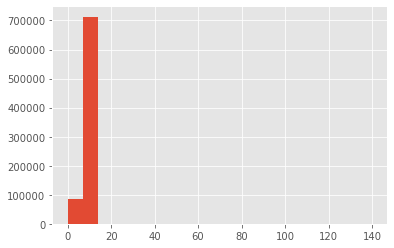

In [14]:
#using the concept of flooring and capping
print(dd['Visibility(mi)'].quantile(0.10)) #6
print(dd['Visibility(mi)'].quantile(0.90)) #10.0
print(dd['Visibility(mi)'].skew())  #4.37

#Filling the Visibility column missing values with its mean
dd_Visibility=dd["Visibility(mi)"]
#plotting the Pressure histogram
dd_Visibility.hist(bins=20)
#approximately follows normal distribution
print(dd["Visibility(mi)"].isnull().sum())
#filling the missing values with the concept of flooring and capping
median_Visibility=dd_Visibility.median()
mean_Visibility=dd_Visibility.mean()
print(mean_Visibility,median_Visibility)
#calculating the median and mean pressure and it is left-skewed ditribution
dd["Visibility(mi)"] = np.where(dd["Visibility(mi)"] <6.0, 6.0,dd['Visibility(mi)'])
dd["Visibility(mi)"] = np.where(dd["Visibility(mi)"] >10.0, 10.0,dd['Visibility(mi)'])
print(dd['Visibility(mi)'].skew())
#improved skew value from 4.37 to -1.84
#new mean and median
new_median_Visibility=dd_Visibility.median()
new_mean_Visibility=dd_Visibility.mean()
print(new_mean_Visibility,new_median_Visibility)
dd["Visibility(mi)"].fillna(new_median_Visibility, inplace=True)
#ensuring that there are no more null values in visibility
print(dd['Visibility(mi)'].isnull().sum())

print(dd.isnull().sum())

3.5
10.0
6.5
0 11845
0.0
13.8
38.51312041083414


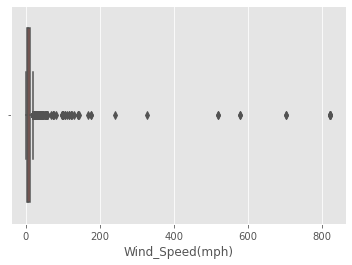

In [15]:
#plotting the box plots and finding the outliers
sns.boxplot(data=dd,x=dd['Wind_Speed(mph)'])
Q1=dd['Wind_Speed(mph)'].quantile(0.25)
Q3=dd['Wind_Speed(mph)'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
iqr_range=1.5*IQR
Lower_bound=Q1-iqr_range
Upper_bound=Q3+iqr_range
lower_outliers=dd[dd['Wind_Speed(mph)']<Lower_bound]
upper_outliers=dd[dd['Wind_Speed(mph)']>Upper_bound]
print(len(lower_outliers),len(upper_outliers))


#it is skewed


#using the concept of flooring and capping
print(dd['Wind_Speed(mph)'].quantile(0.10)) #0
print(dd['Wind_Speed(mph)'].quantile(0.90)) #13.8
print(dd['Wind_Speed(mph)'].skew())  #38.513

133385
7.202029585625658 6.9
-1.8771269304270366
6.865819384291232 6.9
0


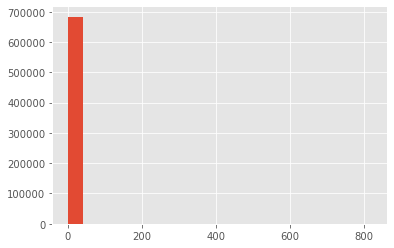

In [16]:
#Filling the Visibility column missing values with its mean
dd_Windspeed=dd["Wind_Speed(mph)"]
#plotting the Pressure histogram
dd_Windspeed.hist(bins=20)
#approximately follows normal distribution
print(dd["Wind_Speed(mph)"].isnull().sum())
#filling the missing values with the concept of flooring and capping
median_Windspeed=dd_Windspeed.median()
mean_Windspeed=dd_Windspeed.mean()
print(mean_Windspeed,median_Windspeed)
#calculating the median and mean pressure and it is left-skewed ditribution
dd["Wind_Speed(mph)"] = np.where(dd["Wind_Speed(mph)"] <0, 0,dd['Wind_Speed(mph)'])
dd["Wind_Speed(mph)"] = np.where(dd["Wind_Speed(mph)"] >13.8, 13.8,dd['Wind_Speed(mph)'])
print(dd['Visibility(mi)'].skew())
#improved skew value from 38 to -1.84
#new mean and median
new_median_Windspeed=dd_Windspeed.median()
new_mean_Windspeed=dd_Windspeed.mean()
print(new_mean_Windspeed,new_median_Windspeed)
dd["Wind_Speed(mph)"].fillna(new_median_Windspeed, inplace=True)
#ensuring that there are no more null values in visibility
print(dd['Wind_Speed(mph)'].isnull().sum())

In [17]:
#Wind_Direction

#filling the category with the mode 
mode_found=(dd['Wind_Direction'].mode())
print(mode_found[0])
dd["Wind_Direction"].fillna(mode_found[0], inplace=True)
print(dd['Wind_Direction'].isnull().sum())




print(dd.isnull().sum())



#Weather_Condition
#filling the category with the mode 
mode_found=(dd['Weather_Condition'].mode())
print(mode_found[0])
dd["Weather_Condition"].fillna(mode_found[0], inplace=True)
print(dd['Weather_Condition'].isnull().sum())


Calm
0
Unnamed: 0                0
ID                        0
Source                    0
Severity                  0
Start_Time                0
End_Time                  0
Start_Lat                 0
Start_Lng                 0
Distance(mi)              0
Description               0
Street                    0
Side                      0
City                      8
County                    0
State                     0
Zipcode                 307
Country                   0
Timezone                307
Airport_Code            328
Temperature(F)            0
Humidity(%)               0
Pressure(in)              0
Visibility(mi)            0
Wind_Direction            0
Wind_Speed(mph)           0
Weather_Condition     16391
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop         

In [18]:
#City
#filling the category with the mode 
mode_found=(dd['City'].mode())
print(mode_found[0])
dd["City"].fillna(mode_found[0], inplace=True)
print(dd['City'].isnull().sum())




#Sunrise_sunset
#filling the category with the mode 
mode_found=(dd['Sunrise_Sunset'].mode())
print(mode_found[0])
dd["Sunrise_Sunset"].fillna(mode_found[0], inplace=True)
print(dd['Sunrise_Sunset'].isnull().sum())
#dropping the cols 'Zipcode','Timezone','Airport_Code' 
unwanted_cols_2=['Zipcode','Timezone','Airport_Code']
dd.drop(unwanted_cols_2, axis=1,inplace=True)

print(dd.isnull().sum())

Los Angeles
0
Day
0
Unnamed: 0            0
ID                    0
Source                0
Severity              0
Start_Time            0
End_Time              0
Start_Lat             0
Start_Lng             0
Distance(mi)          0
Description           0
Street                0
Side                  0
City                  0
County                0
State                 0
Country               0
Temperature(F)        0
Humidity(%)           0
Pressure(in)          0
Visibility(mi)        0
Wind_Direction        0
Wind_Speed(mph)       0
Weather_Condition     0
Amenity               0
Bump                  0
Crossing              0
Give_Way              0
Junction              0
No_Exit               0
Railway               0
Roundabout            0
Station               0
Stop                  0
Traffic_Calming       0
Traffic_Signal        0
Sunrise_Sunset        0
Year                  0
Month                 0
Day                   0
Hour                  0
Weekday             